# CLIP Model

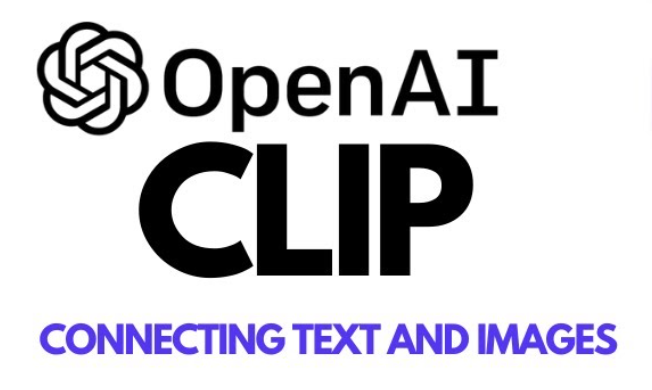 <br>
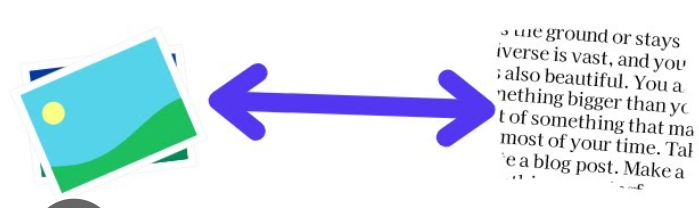

<br> <br>
#### CLIP (Contrastive Language-Image Pretraining) is a powerful multimodal vision and language model developed by OpenAI. It was introduced in a research paper titled "Learning Transferable Visual Models From Natural Language Supervision" in January 2021. CLIP is designed to understand and connect images and their associated natural language descriptions in a joint embedding space.

The main idea behind CLIP is to leverage a large dataset of image-text pairs to learn a shared representation for both images and text, where similar images and their descriptions are brought closer together, while dissimilar pairs are pushed apart. This is achieved through a contrastive learning approach.

Key components and features of the CLIP model:

1. **Architecture**: CLIP combines a vision model and a language model into a unified architecture. It uses a vision model based on the Vision Transformer (ViT) architecture, which is a powerful transformer-based neural network that has shown impressive performance on image-related tasks. The language model is based on a transformer as well.

2. **Training Objective**: CLIP employs a contrastive loss function during training. Given an image and its associated text, the contrastive loss aims to pull the image and text representations closer in the joint embedding space while pushing away unrelated image-text pairs.

3. **Large-scale Datasets**: CLIP is pre-trained on a massive dataset of image-text pairs from the internet. These pairs are collected without explicit alignment, meaning that the model learns to associate images and their corresponding descriptions purely based on the data's co-occurrence.

4. **Multimodal Understanding**: CLIP learns to understand the semantic relationships between images and their captions. For example, it can identify objects, attributes, and even complex concepts described in natural language.

5. **Zero-shot Learning**: One of the significant advantages of CLIP is its ability to perform zero-shot learning. This means that the model can recognize objects and concepts in images that were not seen during training, solely based on their textual descriptions.

6. **Applications**: CLIP has a wide range of applications, including image classification, object detection, image generation, and even tasks involving language such as natural language understanding and question-answering.

The CLIP model represents a significant advancement in multimodal learning, as it demonstrates the ability to connect vision and language effectively. It achieves state-of-the-art results on various benchmarks and has become a crucial component in the field of computer vision and natural language processing.

In [ ]:
batch_size = 4
num_epochs = 25
image_size = 256

# Import Libaries

In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.utils import make_grid
import torch
import torch.optim as optim
import itertools
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Load and Preprocess Image Captioning data

1. Retrieves a list of image filenames from the specified directory (`image_folder`) that contain images in either '.jpg' or '.png' format.

2. Loads a DataFrame (`text_data`) that presumably contains information about image captions, where each row corresponds to an image and contains one or more captions associated with that image.

3. For each image filename in the list, it searches for the corresponding captions in the DataFrame (`text_data`) based on the 'image_name' column.

4. Sorts the captions for each image in descending order based on the 'number_of_words' column (assuming this column exists in `text_data`), which might be used for prioritizing longer captions.

5. Extracts the top two captions (presumably one for training and one for testing) after sorting and appends them to separate lists (`train_captions` and `test_captions`) for further use in training and evaluating an image captioning model.

In [ ]:
text_data = pd.read_csv("/kaggle/input/flickr8k/captions.txt", sep="|")
text_data["number_of_words"] = text_data["caption_text"].apply(lambda text: len(text.split()))
text_data

In [ ]:
image_folder = '/kaggle/input/flickr8k/images'
image_filenames = os.listdir(image_folder)
image_filenames = [filename for filename in image_filenames if filename.endswith(('.jpg', '.png'))]

# image_filenames = image_filenames[0:100]

train_captions = []
test_captions = []
for image_filename in tqdm(image_filenames):
    caption = text_data[text_data['image_name']==image_filename].sort_values(by="number_of_words",ascending=False).reset_index(drop=True)['caption_text']
    train_caption = caption[0]
    test_caption = caption[1]
    train_captions.append( train_caption )
    test_captions.append( test_caption )

In [ ]:
import os
# Get the number of available processors
num_processors = os.cpu_count()

# Example dataset class
class ImageTextDataset(Dataset):
    def __init__(self, image_filenames, captions, image_size=224):
        self.image_filenames = image_filenames
        self.captions = captions
        self.transform = transforms.Compose([
                                                transforms.Resize((image_size, image_size)),  # Resize images to a consistent size
                                                transforms.ToTensor(),          # Convert images to tensors
                                                # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize images
                                            ])
    
    def __len__(self):
        return len(self.image_filenames)
    
    def __getitem__(self, index):
        image = Image.open("/kaggle/input/flickr8k/images/"+image_filenames[index])
        image = self.transform(image) # .permute(2,1,0)
        text = self.captions[index]
        
        return image, text

# Create an instance of the dataset
train_dataset = ImageTextDataset(image_filenames, train_captions, image_size)
test_dataset = ImageTextDataset(image_filenames, test_captions, image_size)

# Create a DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True ) # , prefetch_factor=num_processors, num_workers=1, pin_memory=True, drop_last=True
test_dataloader = DataLoader(test_dataset, batch_size=batch_size*16, shuffle=False ) # , prefetch_factor=num_processors, num_workers=1, pin_memory=True, drop_last=False

In [ ]:
# i=0
# train_dataset.__getitem__(i)[0].shape, train_dataset.__getitem__(i)[1]

# Display Few Image with Caption

In [ ]:
# Fetch a batch from the dataloader
batch_images, batch_texts = next(iter(train_dataloader))

for index in range(batch_images.shape[0]):
    # Fetch the image and text for the chosen index
    image_to_display = batch_images[index]
    text_to_display = batch_texts[index]

    # Convert the image tensor to a NumPy array
    image_to_display_np = image_to_display.permute(1, 2, 0).numpy()

    # Display the image using matplotlib
    plt.imshow(image_to_display_np)
    plt.axis('off')  # Turn off axis labels
    plt.show()

    # Display the corresponding text
    print("Caption:", text_to_display, "\n\n\n")
    if index>=5:
        break

# Image Encoder | ViT Model (Vision Transformer Model)

#### Vision Transformers (ViT) is a deep learning model architecture specifically designed for image recognition tasks. It was introduced in a research paper titled "An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale" by Alexey Dosovitskiy et al. in 2020. ViT applies the transformer architecture, which was originally developed for natural language processing, to the domain of computer vision.

Key features of the Vision Transformers (ViT) model:

1. **Transformers for Vision**: Unlike traditional convolutional neural networks (CNNs) commonly used in computer vision tasks, ViT utilizes the transformer architecture, which has been highly successful in natural language processing tasks. Transformers are based on self-attention mechanisms that allow capturing global dependencies between different elements in the input sequence.

2. **Patch Embeddings**: In ViT, an input image is divided into a fixed number of non-overlapping patches, and each patch is treated as a token similar to words in natural language processing tasks. These patches are then linearly embedded into a lower-dimensional feature space.

3. **Positional Embeddings**: As transformers lack the inherent notion of spatial relationships present in CNNs, ViT introduces positional embeddings to provide the model with positional information of the patches in the image. These positional embeddings are added to the patch embeddings to preserve positional knowledge.

4. **Transformer Encoder**: ViT consists of multiple layers of the transformer encoder. Each encoder layer performs self-attention, where each patch can attend to other patches in the image, and then a feed-forward neural network is applied to process the attended features.

5. **Pretraining and Transfer Learning**: Similar to other large-scale vision models, ViT is typically pre-trained on large datasets, such as ImageNet-1k, with a self-supervised learning approach. After pretraining, the model can be fine-tuned on specific downstream tasks with smaller labeled datasets, making it a powerful transfer learning tool.

6. **Scale**: One of the advantages of ViT is that it can be scaled up to handle high-resolution images effectively. Unlike CNNs, where increasing the resolution would lead to significant computational overhead, ViT handles resolution easily through the patch-based processing.

7. **Attention Mechanism**: The attention mechanism in ViT allows the model to capture long-range dependencies and relationships between patches, making it effective for tasks that require global context understanding.

8. **Image Classification**: ViT is primarily used for image classification tasks, where the model takes an image as input, processes it through the transformer encoder, and produces a prediction for the class label.


In [ ]:
def image_preprocessing(image_path, target_size):
    # Load the image using PIL
    img = Image.open(image_path)
    # Resize the image using PIL's resize method
    img = img.resize(target_size, Image.Resampling.LANCZOS)
    # Convert the resized image to a NumPy array
    processed_image_array = np.array(img)
    return processed_image_array

def display_image(image_array):
    # Display the image using matplotlib
    plt.imshow(image_array)
    plt.axis('off')  # Turn off axis labels
    plt.show()

In [ ]:
image = image_preprocessing("/kaggle/input/flickr8k/images/1007320043_627395c3d8.jpg",(image_size,image_size))
display_image(image)

In [ ]:
import torch
import matplotlib.pyplot as plt

def create_image_patches(image, patch_size):
    batch_size, channels, height, width = image.size()
    patches = []
    for h in range(0, height, patch_size):
        for w in range(0, width, patch_size):
            patch = image[:, :, h:h+patch_size, w:w+patch_size]
            patches.append(patch)
    patches = torch.cat(patches, dim=0)
    return patches

def plot_patches(patches):
    num_patches = patches.size(0)
    n = int(np.sqrt(num_patches))
    plt.figure(figsize=(2*n, 2*n))
    for i in range(num_patches):
        patch = patches[i].permute(1, 2, 0).numpy()
        plt.subplot(n, n, i + 1)
        plt.imshow(patch)
        plt.title(f"Patch {i+1}")
        plt.axis('off')
    plt.show()

# Example usage
image_size = 256
patch_size = 16

image_array = image_preprocessing("/kaggle/input/flickr8k/images/1007320043_627395c3d8.jpg", (image_size,image_size)) # shape: (image_size, image_size, 3)
plt.imshow(image_array)
plt.axis('off')  # Turn off axis labels
plt.show()
input_image = torch.tensor(image_array).permute(2,0,1).unsqueeze(0) # shape: (1, 3, image_size, image_size)
input_batch_image = torch.stack([input_image,input_image,input_image,input_image])
patches = create_image_patches(input_image, patch_size)
print(patches.shape)
plot_patches(patches)

In [ ]:
def create_batch_patches(input_batch_image):
    batch_patches = []
    for i in range(input_batch_image.shape[0]):
        input_image = input_batch_image[i].unsqueeze(0)
        patches = create_image_patches(input_image, patch_size)
        batch_patches.append(patches)
    return torch.stack(batch_patches, dim=0)

image_array = image_preprocessing("/kaggle/input/flickr8k/images/1007320043_627395c3d8.jpg", (image_size,image_size)) # shape: (image_size, image_size, 3)
input_image = torch.tensor(image_array).permute(2,0,1)
input_batch_image = torch.stack([input_image,input_image,input_image,input_image])
print(input_batch_image.shape)
batch_patches = create_batch_patches(input_batch_image)
print(batch_patches.shape)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_heads):
        super(MultiHeadAttention, self).__init__()
        self.d_model = d_model
        self.n_heads = n_heads
        self.head_dim = d_model // n_heads

        self.query = nn.Linear(d_model, d_model)
        self.key = nn.Linear(d_model, d_model)
        self.value = nn.Linear(d_model, d_model)
        self.fc_out = nn.Linear(d_model, d_model)

    def forward(self, query, key, value, mask=None):
        batch_size = query.shape[0]

        Q = self.query(query)
        K = self.key(key)
        V = self.value(value)

        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).transpose(1, 2)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).transpose(1, 2)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).transpose(1, 2)

        scores = torch.matmul(Q, K.transpose(-1, -2)) / torch.sqrt(torch.tensor(self.head_dim, dtype=torch.float32))
        
        if mask is not None:
            scores = scores.masked_fill(mask == 0, float("-inf"))

        attention = torch.softmax(scores, dim=-1)
        attended_values = torch.matmul(attention, V)
        attended_values = attended_values.transpose(1, 2).contiguous().view(batch_size, -1, self.d_model)
        
        output = self.fc_out(attended_values)
        return output, attention

class TransformerBlock(nn.Module):
    def __init__(self, d_model, n_heads, dim_feedforward, dropout=0.1):
        super(TransformerBlock, self).__init__()
        self.attention = MultiHeadAttention(d_model, n_heads)
        self.norm1 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.fc = nn.Sequential(
                                    nn.Linear(d_model, dim_feedforward),
                                    nn.ReLU(),
                                    nn.Linear(dim_feedforward, d_model),
                                )
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        attended, attention = self.attention(x, x, x, mask)
        x = x + self.dropout1(self.norm1(attended))
        feedforward = self.fc(x)
        x = x + self.dropout2(self.norm2(feedforward))
        return x, attention

class VisionTransformer(nn.Module):
    def __init__(self, image_size, patch_size, d_model, n_heads, image_embedding_size, dim_feedforward, num_layers, dropout=0.1):
        super(VisionTransformer, self).__init__()
        assert image_size % patch_size == 0, "Image dimensions must be divisible by the patch size."
        num_patches = (image_size // patch_size) ** 2
        self.patch_size = patch_size
        
        self.patch_dim = 3 * patch_size ** 2
        self.patch_embeddings = nn.Linear(self.patch_dim, d_model)
        self.position_embeddings = self.generate_positional_encodings(num_patches + 1, d_model) # nn.Parameter(torch.zeros(1, num_patches + 1, d_model))
        self.cls_token = nn.Parameter(torch.zeros(1, 1, d_model))
        self.dropout = nn.Dropout(dropout)

        self.transformer_blocks = nn.ModuleList([TransformerBlock(d_model, n_heads, dim_feedforward, dropout)
            for _ in range(num_layers)
        ])

        self.fc_head = nn.Linear(d_model, image_embedding_size)
        # self.fc = nn.Linear(image_embedding_size, 10)
        
    def generate_positional_encodings(self, num_patches, d_model):
        position_encodings = torch.zeros(1, num_patches, d_model)  # Add +1 to num_patches
        position = torch.arange(0, num_patches, dtype=torch.float32).unsqueeze(1)  # Add +1 to num_patches
        div_term = torch.exp(torch.arange(0, d_model, 2, dtype=torch.float32) * (-math.log(10000.0) / d_model))
        position_encodings[:, :, 0::2] = torch.sin(position * div_term)
        position_encodings[:, :, 1::2] = torch.cos(position * div_term)
        return position_encodings

        
    def create_image_patches(self, image):
        batch_size, channels, height, width = image.size()
        patches = []
        for h in range(0, height, self.patch_size):
            for w in range(0, width, self.patch_size):
                patch = image[:, :, h:h+self.patch_size, w:w+self.patch_size]
                patches.append(patch)
        patches = torch.cat(patches, dim=0)
        return patches
    
    def create_batch_patches(self,input_batch_image):
        batch_patches = []
        for i in range(input_batch_image.shape[0]):
            input_image = input_batch_image[i].unsqueeze(0)
            patches = self.create_image_patches(input_image)
            batch_patches.append(patches)
        return torch.stack(batch_patches, dim=0).float()
    
    
    def forward(self, x):
        batch_size = x.shape[0]
        x = self.create_batch_patches(x)
        x = x.reshape(x.size(0), x.size(1), x.size(2)*x.size(3)*x.size(4))
        x = self.patch_embeddings(x)
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.position_embeddings.to(x.device)
        for transformer in self.transformer_blocks:
            x, _ = transformer(x)

        x = x[:, 0]
        x = self.dropout(x)
        x = self.fc_head(x)
        # x = self.fc(x)
        return x

In [ ]:
# Example usage
image_size = 256
patch_size = 16
d_model = 512*2
n_heads = 8
dim_feedforward = 2048
num_layers = 12
image_embedding_size=1024*4

model = VisionTransformer(image_size, patch_size, d_model, n_heads, image_embedding_size, dim_feedforward, num_layers)
model.to(device)

image_array = image_preprocessing("/kaggle/input/flickr8k/images/1007320043_627395c3d8.jpg", (image_size,image_size)) # shape: (image_size, image_size, 3)
input_image = torch.tensor(image_array).permute(2,0,1) # .to(device)
input_batch_image = torch.stack([input_image,input_image,input_image,input_image]).to(device)

output = model(input_batch_image)
print(output.shape)

# Checking ViT using classification data

In [ ]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# import torchvision.transforms as transforms
# from torch.utils.data import DataLoader
# from torchvision.datasets import CIFAR10  # You can use your own dataset

# # Hyperparameters
# batch_size = 32
# num_epochs = 10
# learning_rate = 0.001
# num_classes = 10  # Change this to match the number of classes in your dataset

# # Data preprocessing and loading
# transform = transforms.Compose([transforms.Resize((256, 256)),
#                                 transforms.ToTensor(),
#                                 transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                                                      std=[0.229, 0.224, 0.225])])

# train_dataset = CIFAR10(root='./data', train=True, transform=transform, download=True)
# test_dataset = CIFAR10(root='./data', train=False, transform=transform, download=True)

# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# # Loss and optimizer
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# model.to(device)
# # Training loop
# for epoch in range(num_epochs):
#     batch_idx = 0
#     for images, labels in train_loader:
#         images = images.to(device)
#         labels = labels.to(device)
#         outputs = model(images)
#         loss = criterion(outputs, labels)
        
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
        
#         if batch_idx % 25 == 0:
#             print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx}/{len(train_loader)}], Loss: {loss.item():.4f}")
#         batch_idx+=1
#     print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item()}')

In [ ]:
# # Evaluation
# model.eval()
# with torch.no_grad():
#     correct = 0
#     total = 0
#     for images, labels in test_loader:
#         images = images.to(device)
#         labels = labels.to(device)
#         outputs = model(images)
#         _, predicted = torch.max(outputs.data, 1)
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()

#     accuracy = 100 * correct / total
#     print(f'Accuracy on test data: {accuracy}%')

# Text Encoder

#### BERT (Bidirectional Encoder Representations from Transformers) is a natural language processing (NLP) model introduced by Jacob Devlin et al. in 2018. It is a transformer-based architecture that revolutionized many NLP tasks with its pretraining and fine-tuning approach. Here's a short description of BERT:

1. **Bidirectional Context**: BERT is designed to capture bidirectional context information by using a "masked language model" (MLM) pretraining task. During pretraining, input sentences are randomly masked, and the model learns to predict the masked words based on both left and right context, enabling a deeper understanding of word meanings.

2. **Transformer Architecture**: BERT's core architecture is based on the transformer, which includes self-attention mechanisms to capture dependencies between words in a sentence. It consists of multiple encoder layers that process the input text.

3. **Pretraining and Fine-Tuning**: BERT is pretrained on a large corpus of text data using the MLM task. After pretraining, the model is fine-tuned on specific downstream NLP tasks, such as text classification, named entity recognition, question-answering, etc. This fine-tuning process allows BERT to be adapted to various NLP tasks with smaller labeled datasets.

4. **Contextual Word Embeddings**: Unlike traditional word embeddings like Word2Vec and GloVe, BERT generates contextualized word embeddings, meaning the representation of a word can vary depending on its context within a sentence. This enables BERT to better understand polysemy and word sense disambiguation.

5. **State-of-the-Art Performance**: BERT achieved state-of-the-art performance on various NLP benchmarks and tasks, surpassing previous models that relied on static word embeddings and traditional sequence models.


In [ ]:
import torch
from transformers import DistilBertTokenizer, DistilBertModel, AutoTokenizer

# Load pre-trained DistilBERT model and tokenizer
model_name = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name) # DistilBertTokenizer.from_pretrained(model_name)
model = DistilBertModel.from_pretrained(model_name)

def generate_text_embeddings(texts):
    # Tokenize input texts
    inputs = tokenizer(texts, return_tensors='pt', padding=True, truncation=True)

    # Generate embeddings
    with torch.no_grad():
        outputs = model(**inputs)

    # Get the embeddings from the last hidden layer
    embeddings = outputs.last_hidden_state[:, 0, :] # <---CLS # outputs.last_hidden_state.mean(dim=1)  # You can use other aggregation methods

    return embeddings

In [ ]:
# List of input texts
texts = [ "yo yo CLIP Model", "DistilBERT is a great model for text embedding.", "Vision Transformers for image.", "Contrative Learning" ]

# Generate embeddings
embeddings = generate_text_embeddings(texts)
print("Shape of embeddings:", embeddings.shape)  # Should print (num_texts, embedding_size)

In [ ]:
"""
pip install -U sentence-transformers# 

from sentence_transformers import SentenceTransformer, util

# Load a pre-trained Sentence Transformer model
model_name = 'paraphrase-MiniLM-L6-v2'
model = SentenceTransformer(model_name)

# Compute embeddings for the sentences
sentence_embeddings = model.encode(texts, convert_to_tensor=True)

# Print the embeddings
for sentence, embedding in zip(texts, sentence_embeddings):
    print("Sentence:", sentence)
    print("Embedding:", embedding.shape)
    print()
    
"""

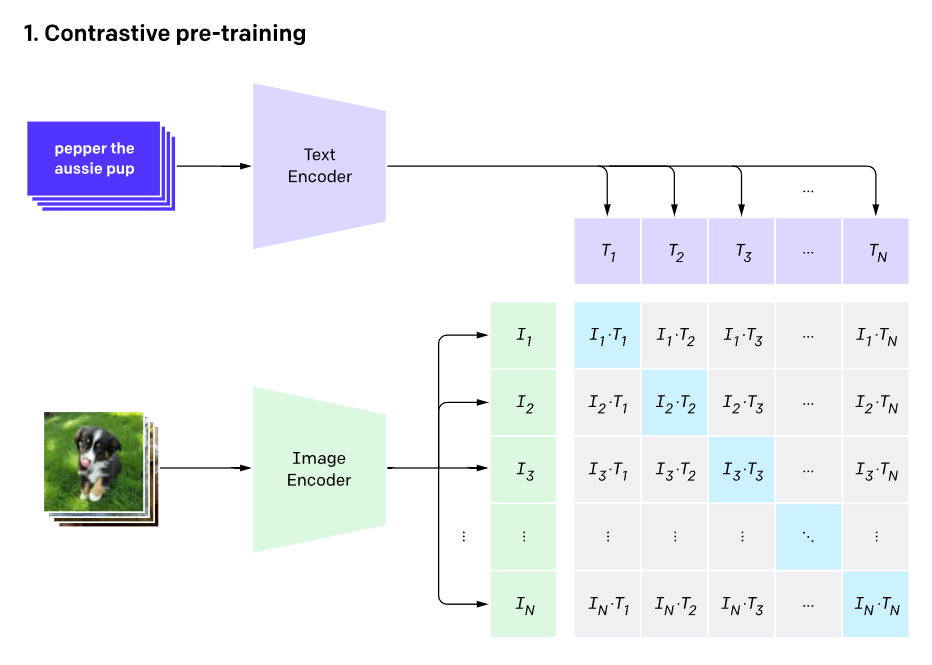

# Contrastive learning
#### Contrastive learning is a type of self-supervised learning technique that aims to learn useful representations by contrasting positive pairs (similar samples) against negative pairs (dissimilar samples). It is particularly effective for learning visual representations without the need for explicit annotations. Contrastive learning has been widely used in computer vision tasks and plays a crucial role in models like CLIP (Contrastive Language-Image Pretraining).

In the context of the CLIP model, contrastive learning is used to train the joint vision and language encoder. The model learns to map images and text into a shared embedding space, where the representations of similar image-text pairs are pulled closer together, while dissimilar pairs are pushed further apart.

Here's how contrastive learning is applied in the CLIP model:

1. **Positive Pairs**: For each image, a positive pair is created by associating it with a relevant caption or text that accurately describes the image. The model's objective is to bring the representations of the image and its corresponding text closer together in the embedding space.

2. **Negative Pairs**: For each image, multiple negative pairs are created by associating it with captions or text that do not match or describe the image. The model's objective is to push the representations of these negative pairs away from the image representation in the embedding space.

3. **Contrastive Loss**: The contrastive loss function is used to train the model. It encourages the similarity between positive pairs and increases the dissimilarity between positive pairs and negative pairs. The loss is typically based on the cosine similarity or dot product of the image-text embeddings.

4. **Training Procedure**: During training, the CLIP model is fed with positive and negative pairs of image-text data. It learns to encode images and text in a way that similar image-text pairs have embeddings that are close together, while dissimilar pairs have embeddings that are far apart.

By leveraging contrastive learning, the CLIP model can learn powerful joint image-text representations. These representations can then be used for various tasks, such as image classification, image-text retrieval, and zero-shot learning, where the model can perform on unseen image-text pairs without explicit training on them. Contrastive learning, combined with the large-scale pretraining of CLIP, has shown remarkable performance on a wide range of vision and language tasks, making it a powerful and versatile model for cross-modal understanding.

# Numpy-like pseudocode for the core of an implementation of CLIP.
### Paper: Learning Transferable Visual Models From Natural Language Supervision | Link: https://arxiv.org/pdf/2103.00020v1.pdf
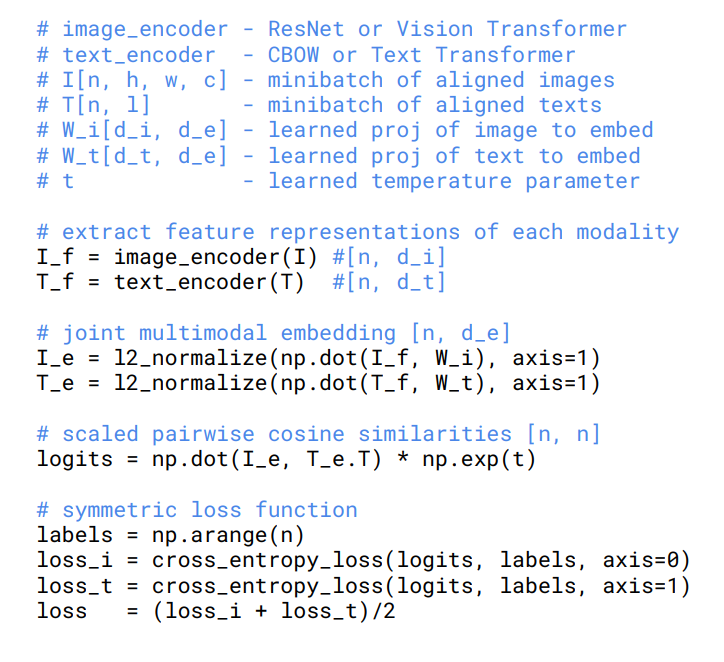

# Model Implementation

In [ ]:
import torch
import torch.nn as nn
dropout = 0.1
class ImageProjection(nn.Module):
    def __init__(self, image_embedding_size, shared_embedding_size):
        super(ImageProjection, self).__init__()
        self.image_projection = nn.Linear(image_embedding_size, shared_embedding_size)
        self.gelu = nn.GELU()
        self.fc = nn.Linear(shared_embedding_size, shared_embedding_size)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(shared_embedding_size)
        
    def forward(self, image_embeddings):
        projected_embeddings = self.image_projection(image_embeddings)
        
        x = self.gelu(projected_embeddings)
        x = self.fc(x)
        x = self.dropout(x)
        x = x + projected_embeddings
        x = self.layer_norm(x)
        
        return x # projected_embeddings

class TextProjection(nn.Module):
    def __init__(self, text_embedding_size, shared_embedding_size):
        super(TextProjection, self).__init__()
        self.text_projection = nn.Linear(text_embedding_size, shared_embedding_size)
        self.gelu = nn.GELU()
        self.fc = nn.Linear(shared_embedding_size, shared_embedding_size)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(shared_embedding_size)
        
    def forward(self, text_embeddings):
        projected_embeddings = self.text_projection(text_embeddings)
        
        x = self.gelu(projected_embeddings)
        x = self.fc(x)
        x = self.dropout(x)
        x = x + projected_embeddings
        x = self.layer_norm(x)
        
        return x # projected_embeddings
        
"""
class CosineSimilarity(nn.Module):
    def __init__(self, temperature = 0.2 ):
        super(CosineSimilarity, self).__init__()
        self.temperature = temperature

    def forward(self, image_embeddings, text_embeddings):
        normalized_images = nn.functional.normalize(image_embeddings, dim=-1)
        normalized_texts = nn.functional.normalize(text_embeddings, dim=-1)
        
        similarities = torch.matmul(normalized_images, normalized_texts.t())*self.temperature
        return similarities
"""

In [ ]:
"""
import torch.nn as nn

class SymmetricalLoss(nn.Module):
    def __init__(self, margin=0.1):
        super(SymmetricalLoss, self).__init__()
        self.margin = margin
        self.cosine_similarity = nn.CosineSimilarity(dim=-1)
        
    def forward(self, image_embeddings, text_embeddings):
        sim_image_to_text = self.cosine_similarity(image_embeddings, text_embeddings)
        sim_text_to_image = self.cosine_similarity(text_embeddings, image_embeddings)
        
        # - - - -  Similarity Loss  - - - - -
#         loss_image_to_text = torch.mean((1 - sim_image_to_text).clamp(min=0))
#         loss_text_to_image = torch.mean((1 - sim_text_to_image).clamp(min=0))
        
        #  - - - -  Cross Entropy Loss  - - - - 
        target = torch.ones_like(sim_image_to_text)  # Label 1 indicates alignment
        loss_image_to_text = nn.functional.binary_cross_entropy_with_logits(sim_image_to_text, target, reduction='mean')
        loss_text_to_image = nn.functional.binary_cross_entropy_with_logits(sim_text_to_image, target, reduction='mean')
        
        total_loss = loss_image_to_text + loss_text_to_image
        return total_loss
    
    
import torch
import torch.nn as nn
import torch.nn.functional as F

class ContrastiveLoss(nn.Module):
    def __init__(self, temperature=1.0):
        super(ContrastiveLoss, self).__init__()
        self.temperature = temperature

    def forward(self, image_features, text_features):
        # Normalize the input features
        image_features = F.normalize(image_features, dim=-1, p=2)
        text_features = F.normalize(text_features, dim=-1, p=2)

        # Calculate similarity scores (dot product)
        similarity_scores = torch.matmul(image_features, text_features.T) / self.temperature

        # Generate labels for positive and negative pairs
        batch_size = similarity_scores.size(0)
        labels = torch.arange(batch_size, device=similarity_scores.device)
        
        # Calculate contrastive loss
        loss = F.cross_entropy(similarity_scores, labels)
        return loss

# Example usage
image_features = torch.rand(16, 512)  # Replace with your image features
text_features = torch.rand(16, 512)   # Replace with your text features

contrastive_loss = ContrastiveLoss(temperature=0.1)
loss = contrastive_loss( image_features, text_features )
print("Contrastive Loss: ", loss.item())
"""

In [ ]:
def count_trainable_parameters(model):
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return trainable_params

In [ ]:
count_trainable_parameters(model)

In [ ]:
import os

# Set the environment variable
os.environ["TOKENIZERS_PARALLELISM"] = "true" 

# Checking Data Setup
for batch_idx, (images, texts) in enumerate(train_dataloader):
    print( "batch_idx: ", batch_idx, " Image Shape: ", images.shape, "Text Count: ", len(texts) )
    plt.imshow( torch.moveaxis( images[0], 0, 2 ).numpy() )
    plt.show()
    print(texts[0])
    break

# Loss Function

This code snippet appears to be related to implementing a contrastive loss function for the CLIP (Contrastive Language-Image Pretraining) model. CLIP is a model that learns to associate images and their corresponding textual descriptions in a common embedding space, enabling it to perform various tasks such as image and text retrieval.

Let's break down the code step by step and explain its functionality in the context of the CLIP model:

1. **Dropout Value** (`dropout = 0.1`):
   This variable indicates the dropout rate, which is a regularization technique used to prevent overfitting in neural networks. A dropout rate of 0.1 means that during training, 10% of the connections in the neural network will be randomly "dropped out" or set to zero in each training iteration to prevent co-adaptation of neurons.

2. **Cross Entropy Loss Function** (`cross_entropy(preds, targets, reduction='none')`):
   This function calculates the cross-entropy loss between predicted values (`preds`) and target values (`targets`). Cross-entropy is a commonly used loss function for classification problems. The function computes the negative log likelihood of the predicted probabilities for the target classes. The `reduction` parameter specifies how the losses are aggregated:
   - `"none"`: Returns individual losses for each data point.
   - `"mean"`: Returns the mean of the individual losses.

3. **Temperature Value** (`temperature_value = 1`):
   The temperature parameter is used to control the concentration of the softmax distribution. A higher temperature value (greater than 1) makes the distribution more uniform, while a lower value (less than 1) sharpens the distribution, making the model more confident in its predictions.

4. **Contrastive CLIP Loss Function** (`contrastive_clip_loss_function(text_projection, image_projection, mode="eval")`):
   This function computes the contrastive loss for the CLIP model. The CLIP model learns to associate text and image projections in such a way that the similarity between corresponding pairs is maximized and the similarity between non-corresponding pairs is minimized.

   - In `"eval"` mode: The function returns the logits, which are the unnormalized scores representing the similarity between text and image projections.
   
   - In `"train"` mode:
     - The function calculates the dot product between the text projections and image projections (`text_projection @ image_projection.T`), and then divides it by the temperature value.
     - It also calculates the dot products of image and text projections within themselves (`images_similarity`, `texts_similarity`).
     - The target probabilities for training are calculated as the softmax of the average of image and text similarities, scaled by the temperature value.
     - Cross-entropy losses are then calculated for both image and text projections using the `cross_entropy` function. These losses measure the dissimilarity between projected pairs and their corresponding targets.
     - The final loss is calculated as the average of the image and text cross-entropy losses and returned.

   - In any other mode: The function returns `None` with a warning message.


### Temperature hyperparameter in CLIP model:
In the context of the CLIP (Contrastive Language-Image Pretraining) model and other similar models, the temperature parameter is used to adjust the concentration or "sharpness" of the softmax distribution applied to the similarity scores or logits. This parameter affects how the model assigns probabilities to different classes or categories based on their scores.

When calculating the similarity scores or logits, the CLIP model computes the dot product between embeddings (for example, between text and image projections) and then scales these scores by dividing by the temperature parameter. Mathematically, if `s` is the dot product score, and `T` is the temperature parameter, the scaled score `z` is calculated as:

```
z = s / T
```

The softmax function then converts these scaled scores into probabilities. The softmax operation involves exponentiating each score and then normalizing the exponentiated scores to obtain a probability distribution. The formula for softmax is:

```
softmax(s) = exp(s) / sum(exp(s))
```

Here's how the temperature parameter affects the softmax distribution:

1. **Higher Temperature (T > 1):**
   - A higher temperature value increases the entropy of the distribution, making it more uniform. This means that even small differences in scores will have a larger effect on the resulting probabilities.
   - The softmax output will be more spread out, giving more equal probabilities to different classes or categories. This can be useful when you want the model to be more explorative and generate more diverse predictions.

2. **Lower Temperature (T < 1):**
   - A lower temperature value sharpens the distribution. Larger differences in scores will have a greater effect on the resulting probabilities.
   - The softmax output will be more peaked, assigning higher probabilities to the class with the highest score and lower probabilities to other classes. This can make the model more confident in its predictions.

In the context of the CLIP model, the temperature parameter is often used during the training process when calculating the similarity scores between images and text. By adjusting the temperature parameter, you can control the balance between encouraging more uniform distribution of scores (exploration) and emphasizing the differences between high and low scores (exploitation).

In practical terms, tuning the temperature parameter can have an impact on the behavior of the model during training and inference. A higher temperature might encourage more diverse and exploratory behavior, while a lower temperature might lead to more focused and confident predictions. The choice of the temperature value depends on the specific application and the desired characteristics of the model's outputs.


Certainly! Let's consider a practical example involving the CLIP model's image captioning task. In this task, the CLIP model takes an image as input and generates a textual description that describes the content of the image.

**Higher Temperature (Exploratory Behavior):**

Imagine you have an image of a beach scene with palm trees, sand, and water. You want the CLIP model to generate a diverse set of captions that capture different aspects of the image. By using a higher temperature value, let's say `T = 2`, you're encouraging more exploratory behavior in the model's captions.

With a higher temperature, the softmax operation will make the model assign more balanced probabilities to different words in the vocabulary for each position in the generated caption. This means that the model will be more likely to consider a wider range of words when generating the caption. As a result, you might get captions like:

- "A sunny day at the sandy beach with palm trees."
- "Palm trees lining the beach under the bright sun."
- "Sandy shores and palm trees against the blue sky."

These captions are more diverse and exploratory, capturing different aspects of the image in each description. The model is less focused on a single "best" caption and is exploring various possibilities.

**Lower Temperature (Confident Predictions):**

Now, consider the same beach image and the same task, but this time you use a lower temperature value, say `T = 0.5`.

With a lower temperature, the softmax operation will amplify the differences between scores. The model will assign higher probabilities to the most likely words according to its scores and will be more confident in its predictions. As a result, you might get captions like:

- "Sunny beach with palm trees and clear blue water."
- "Palm trees and sandy beach under the sun."
- "Sandy beach with palm trees and blue sky."

These captions are more focused and confident. The model is more likely to generate captions that are very similar to each other, as it's assigning much higher probabilities to specific words that have the highest scores.


In [ ]:
dropout = 0.1

def cross_entropy(preds, targets, reduction='none'):
    log_softmax = nn.LogSoftmax(dim=-1)
    loss = (-targets * log_softmax(preds)).sum(1)
    if reduction == "none":
        return loss
    elif reduction == "mean":
        return loss.mean()

temperature_value = 1

def contrastive_clip_loss_function( text_projection,  image_projection, mode="eval" ):
    logits = (text_projection @ image_projection.T) / temperature_value
    if mode=="train":
        images_similarity = image_projection @ image_projection.T
        texts_similarity = text_projection @ text_projection.T
        targets = F.softmax( (images_similarity + texts_similarity) / 2 * temperature_value, dim=-1 )
        texts_loss = cross_entropy(logits, targets, reduction='none')
        images_loss = cross_entropy(logits.T, targets.T, reduction='none')
        loss =  (images_loss + texts_loss) / 2.0 # shape: (batch_size)
        return loss.mean()
    elif mode=="eval":
        return logits
    else:
        print("Mention mode")
        return None

# Previous Model Setups

In [ ]:
"""

dropout = 0.1

class CLIPModel(torch.nn.Module):
    def __init__(self, shared_embedding_size, learning_rate):
        super(CLIPModel, self).__init__()
        
        # Set up hyperparameters
        self.shared_embedding_size = shared_embedding_size
        self.learning_rate = learning_rate
        
        # - - - - - - - - -  Distil BERT Model  - - - - - - - - -
        max_length = 32
        text_embedding_size = 768  # d_i

        # Load pre-trained DistilBERT model and tokenizer
        model_name = 'distilbert-base-uncased'
        self.text_tokenizer = DistilBertTokenizer.from_pretrained(model_name) # .to(device)
        self.text_model = DistilBertModel.from_pretrained(model_name).to(device)
        print(" Number of Trainable Parameters in", " DistilBERT model :  ",   count_trainable_parameters(self.text_model))
        
        
        # - - - - - - - - - ViT Model - - - - - - - - -
        
        image_size = 224
        patch_size = 16
        d_model = 512*2
        n_heads = 8
        dim_feedforward = 2048
        num_layers = 12
        image_embedding_size=1024*4  # d_i
        
        self.ViT_model = VisionTransformer(image_size, patch_size, d_model, n_heads, image_embedding_size, dim_feedforward, num_layers).to(device)
        print(" Number of Trainable Parameters in", " ViT model :  ",   count_trainable_parameters(self.ViT_model))        
        
        
        # - - - - - - - - -  Projections  - - - - - - - - -
        self.image_projector = ImageProjection(image_embedding_size, shared_embedding_size).to(device)
        print(" Number of Trainable Parameters in", " Image Projection :  ",   count_trainable_parameters(self.image_projector))
        self.text_projector = TextProjection(text_embedding_size, shared_embedding_size).to(device)
        print(" Number of Trainable Parameters in", " Text Projection :  ",   count_trainable_parameters(self.text_projector))
        
        
        # Set up optimizer
        self.optimizer = optim.Adam(    list(self.ViT_model.parameters()) + list(self.text_model.parameters()) +
                                        list(self.image_projector.parameters()) + list(self.text_projector.parameters()),
                                        lr=self.learning_rate )
        
        # - - - - - - - - -  Loss  - - - - - - - - -
        # sym_loss_fn = SymmetricalLoss(margin=0.1).to(device)
        # self.contrastive_loss = ContrastiveLoss(temperature=0.1)
        
        
    def forward(self, images, text_inputs):
        # - - - -  Text  - - - - 
        inputs = text_inputs.to(device)
        outputs = self.text_model(**inputs)
        text_embeddings = outputs.last_hidden_state[:, 0, :] # outputs.last_hidden_state.mean(dim=1)
        text_projection = self.text_projector(text_embeddings)

        # - - - -  Image  - - - -
        images = images.to(device)
        image_embeddings = self.ViT_model(images)
        image_projection = self.image_projector(image_embeddings)

        # - - - -  Compute Loss  - - - -
        # loss = sym_loss_fn(image_projection, text_projection)
        # loss = self.contrastive_loss(image_projection, text_projection)
        loss = contrastive_clip_loss_function( text_projection,  image_projection)
        
        # - - - - Similarity Logits - - - - 
        
        return loss

    
#   - - - - - - - - - - - - - - - - - -   Hyperparameters    - - - - - - - - - - - - - - - - - -
shared_embedding_size = 1028*3  # d_e shared embedding space
learning_rate = 1e-4
model = CLIPModel( shared_embedding_size, learning_rate )
print(" Total Number of Trainable Parameters in", " CLIP Model :  ",   count_trainable_parameters(model)) # 66362880 + 105987072 + 12635148 + 2371596
model

"""

In [ ]:
"""
for batch in train_dataloader:
    images, texts = batch
    print(images.shape)
    break    
"""

In [ ]:
"""

# Create a visualization of the model's computation graph
max_length = 32
text_inputs = tokenizer(texts[0], return_tensors='pt', padding="max_length", max_length=max_length, truncation=True)
graph = make_dot(model(images[0].unsqueeze(0), text_inputs), params=dict(model.named_parameters()))

# Save the graph to a file (optional)
graph.render("model_graph", format="png")

"""

In [ ]:
"""
# - - - - - - - - -  Training loop  - - - - - - - - -
num_epochs = 10

for p in model.parameters():
    p.requires_grad = True
        
model.train()

optimizer = torch.optim.AdamW( params=list(model.parameters()) )
max_length = 16

for epoch in tqdm(range(num_epochs)):
    total_loss = 0.0

    print( " - - - - - - - - - - - Epoch:", epoch+1, " - - - - - - - - - - - - "  )
    for batch_idx, (images, texts) in enumerate(train_dataloader):
        # - - - - - - - - -  Forward pass  - - - - - - - - -
        optimizer.zero_grad()
        
        images = images.to(device)
        text_inputs = tokenizer(texts, return_tensors='pt', padding="max_length", max_length=max_length, truncation=True)
        loss = model(images, text_inputs)
        
        # - - - -  Backpropagation  - - - -
        loss.backward()
        optimizer.step()
        
        # - - - - Loss print - - - -
        total_loss += loss.item()
        if batch_idx % batch_size*10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx}/{len(train_dataloader)}], Loss: {loss.item():.4f}")
            

    # - - - - Loss each epoch
    avg_loss = total_loss / len(train_dataloader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.4f}")
    
"""

In [ ]:
"""
#   - - - - - - - - - - - - - - - - - -   Hyperparameters    - - - - - - - - - - - - - - - - - -
shared_embedding_size = 1024  # d_e shared embedding space
learning_rate = 5e-5

#  - - - - - - - - - - - - - - - - - -   Create model components   - - - - - - - - - - - - - - - - - -
# - - - - - - - - - ViT Model - - - - - - - - -
image_size = 224
patch_size = 16
d_model = 512*2
n_heads = 8
dim_feedforward = 2048
num_layers = 12
image_embedding_size=1024  # d_i

ViT_model = VisionTransformer(image_size, patch_size, d_model, n_heads, image_embedding_size, dim_feedforward, num_layers).to(device)
print(" Number of Trainable Parameters in", " ViT model :  ",   count_trainable_parameters(ViT_model))

# - - - - - - - - -  Distil BERT Model  - - - - - - - - -
max_length = 32
text_embedding_size = 768  # d_i

# Load pre-trained DistilBERT model and tokenizer
model_name = 'distilbert-base-uncased'
text_tokenizer = DistilBertTokenizer.from_pretrained(model_name) # .to(device)
text_model = DistilBertModel.from_pretrained(model_name ).to(device)
print(" Number of Trainable Parameters in", " DistilBERT model :  ",   count_trainable_parameters(text_model))


# - - - - - - - - -  Projections  - - - - - - - - -
image_projector = ImageProjection(image_embedding_size, shared_embedding_size).to(device)
print(" Number of Trainable Parameters in", " Image Projection :  ",   count_trainable_parameters(image_projector))
text_projector = TextProjection(text_embedding_size, shared_embedding_size).to(device)
print(" Number of Trainable Parameters in", " Text Projection :  ",   count_trainable_parameters(text_projector))
print("\n - - - - - - - - - - \n \n  Training......  ")

# - - - - - - - - -  Loss  - - - - - - - - -
# sym_loss_fn = SymmetricalLoss(margin=0.1).to(device)
# contrastive_loss = ContrastiveLoss(temperature=0.9)

# - - - - - - - - -  Optimizer  - - - - - - - - -
optimizer = optim.AdamW( list(ViT_model.parameters())+ list(text_model.parameters()) + list(image_projector.parameters()) + list(text_projector.parameters()), lr=learning_rate )

# import torch.optim.lr_scheduler as lr_scheduler
# scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5) # step_size=step_size
# warmup_epochs = 25  # Number of epochs for warm-up

# - - - - - - - - -  Training loop  - - - - - - - - -
for epoch in range(num_epochs):
    print( " - - - - - - - - - - - Epoch:", epoch+1, " - - - - - - - - - - - - "  )
    ViT_model.train()
    text_model.train()
    image_projector.train()
    text_projector.train()
    total_loss = 0.0
    
    for batch_idx, (images, texts) in enumerate(train_dataloader):
        # - - - - - - - - -  Forward pass  - - - - - - - - -
        optimizer.zero_grad()
        
        # - - - -  Text  - - - - 
        inputs = tokenizer(texts, return_tensors='pt', padding="max_length", max_length=max_length, truncation=True)
        inputs = inputs.to(device)
        outputs = text_model(**inputs)
        text_embeddings = outputs.last_hidden_state[:, 0, :] # outputs.last_hidden_state.mean(dim=1)
        text_projection = text_projector(text_embeddings)
        
        # - - - -  Image  - - - - 
        images = images.to(device)
        image_embeddings = ViT_model(images)
        image_projection = image_projector(image_embeddings)
        
        # - - - -  Compute Loss  - - - -
        # loss = sym_loss_fn(image_projection, text_projection)
        # loss = contrastive_loss(image_projection, text_projection)
        loss = contrastive_clip_loss_function( text_projection,  image_projection, mode="train")
        
        # - - - -  Backpropagation  - - - -
        loss.backward()
        optimizer.step()
        
#     if epoch < warmup_epochs:
#         scheduler.step(epoch)
#     else:
#         scheduler.step()
        
        # - - - - Loss print - - - -
        total_loss += loss.item()
        if batch_idx % 200 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx}/{len(train_dataloader)}], Loss: {loss.item():.4f}")
            
    # - - - - Loss each epoch
    avg_loss = total_loss / len(train_dataloader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.4f}")
    
"""

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import time

# ResNet Model Loading and Modification

## Pre-trained ResNet Model

The provided code snippet is used to load a pre-trained ResNet model. ResNet (Residual Network) is a deep convolutional neural network architecture known for its effectiveness in image classification and feature extraction tasks. The specific variant used here is ResNet-50.

- `image_embedding_size=1024*2`: This variable sets the desired size of the image embeddings, which will be twice the size of the original ResNet model's output.

- `resnet_model = models.resnet50(pretrained=True)`: This line loads the ResNet-50 model from a pre-trained version available in a deep learning library (such as PyTorch or TensorFlow). The `pretrained=True` argument indicates that the model should be initialized with pre-trained weights, typically trained on a large dataset like ImageNet.

## Removing the Classification Layer

- `list(resnet_model.children())[:-1]`: Here, the code modifies the ResNet model by removing the last layer, which is typically the fully connected classification layer. The `resnet_model` is transformed into a Sequential model containing all the layers except the last one. This step is often done when you want to use the model for feature extraction rather than classification.

## Device Assignment

- `resnet_model.to(device)`: This line moves the ResNet model to a specified computing device (e.g., GPU or CPU). This is important to ensure that any subsequent operations involving the model will be executed on the chosen device. The `device` variable should be previously defined, specifying where you want to run the model (e.g., `device = torch.device("cuda:0")` for GPU or `device = torch.device("cpu")` for CPU).

In summary, this code loads a pre-trained ResNet-50 model, removes its classification layer, and assigns it to a computing device for further use, such as feature extraction or integration into a larger neural network architecture.


# Training Model - ResNet50 + Distil BERT

In [ ]:

#   - - - - - - - - - - - - - - - - - -   Hyperparameters    - - - - - - - - - - - - - - - - - -
shared_embedding_size = 512  # d_e shared embedding space
learning_rate = 5e-4

#  - - - - - - - - - - - - - - - - - -   Create model components   - - - - - - - - - - - - - - - - - -
# - - - - - - - - - ResNet Model - - - - - - - - -
# Load a pre-trained ResNet model
image_embedding_size=1024*2
resnet_model = models.resnet50(pretrained=True)
# Remove the classification layer (the last fully connected layer)
resnet_model = nn.Sequential( *list(resnet_model.children())[:-1] )
resnet_model.to(device)
print(" Number of Trainable Parameters in", " ResNet50 Model :  ",   count_trainable_parameters(resnet_model))

# - - - - - - - - -  Distil BERT Model  - - - - - - - - -
max_length = 32
text_embedding_size = 768  # d_i

# Load pre-trained DistilBERT model and tokenizer
model_name = 'distilbert-base-uncased'
text_tokenizer = DistilBertTokenizer.from_pretrained(model_name) # .to(device)
text_model = DistilBertModel.from_pretrained(model_name ).to(device)
print(" Number of Trainable Parameters in", " DistilBERT model :  ",   count_trainable_parameters(text_model))


# - - - - - - - - -  Projections  - - - - - - - - -
image_projector = ImageProjection(image_embedding_size, shared_embedding_size).to(device)
print(" Number of Trainable Parameters in", " Image Projection :  ",   count_trainable_parameters(image_projector))
text_projector = TextProjection(text_embedding_size, shared_embedding_size).to(device)
print(" Number of Trainable Parameters in", " Text Projection :  ",   count_trainable_parameters(text_projector))
print("\n - - - - - - - - - - \n \n  Training......  ")

# - - - - - - - - -  Loss  - - - - - - - - -
# sym_loss_fn = SymmetricalLoss(margin=0.1).to(device)
# contrastive_loss = ContrastiveLoss(temperature=0.9)

# - - - - - - - - -  Optimizer  - - - - - - - - -
# optimizer = optim.AdamW( list(resnet_model.parameters()) + list(text_model.parameters()) + list(image_projector.parameters()) + list(text_projector.parameters()), lr=learning_rate )
params = [{"params":resnet_model.parameters(), "lr":1e-4 }, {"params":text_model.parameters(), "lr":1e-5}, 
          # {"params":image_projector.parameters(), "lr": }, {"params":text_projector.parameters(), "lr":}
          {"params": itertools.chain( image_projector.parameters(), text_projector.parameters() ), "lr":1e-3 , "weight_decay":1e-3 }
         ]
optimizer = optim.AdamW( params,  weight_decay=0. )
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau( optimizer, mode="min", patience=2 , factor=0.8 )

# - - - - - - - - -  Training loop  - - - - - - - - -
for epoch in range(num_epochs):
    # Record the start time
    start_time = time.time()
    print( " - - - - - - - - - - - Epoch:", epoch+1, " - - - - - - - - - - - - "  )
    resnet_model.train()
    text_model.train()
    image_projector.train()
    text_projector.train()
    total_loss = 0.0
    
    for batch_idx, (images, texts) in enumerate(train_dataloader):
        # - - - - - - - - -  Forward pass  - - - - - - - - -
        optimizer.zero_grad()
        
        # - - - -  Text  - - - - 
        inputs = tokenizer(texts, return_tensors='pt', padding="max_length", max_length=max_length, truncation=True)
        inputs = inputs.to(device)
        outputs = text_model(**inputs)
        text_embeddings = outputs.last_hidden_state[:, 0, :] # outputs.last_hidden_state.mean(dim=1)
        text_projection = text_projector(text_embeddings)
        
        # - - - -  Image  - - - - 
        images = images.to(device)
        # images = preprocess_images(images)
        image_embeddings = resnet_model(images)
        image_projection = image_projector(image_embeddings[:,:,0,0])
        
        # - - - -  Compute Loss  - - - -
        # loss = sym_loss_fn(image_projection, text_projection)
        # loss = contrastive_loss(image_projection, text_projection)
        loss = contrastive_clip_loss_function( text_projection,  image_projection, mode="train")
        
        # - - - -  Backpropagation  - - - -
        loss.backward()
        optimizer.step()

        # - - - - Loss print - - - -
        total_loss += loss.item()
        if batch_idx % 200 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx}/{len(train_dataloader)}], Loss: {total_loss/((batch_idx+1)*batch_size):.4f}")
    
    
    lr_scheduler.step(total_loss)
    
    # Record the end time
    end_time = time.time()
    elapsed_time = end_time - start_time
    # - - - - Loss each epoch
    avg_loss = total_loss / len(train_dataloader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.4f}", "  Time Taken: ", elapsed_time, " seconds" )

# Inference | Image Retrieval | ResNet50 Setup
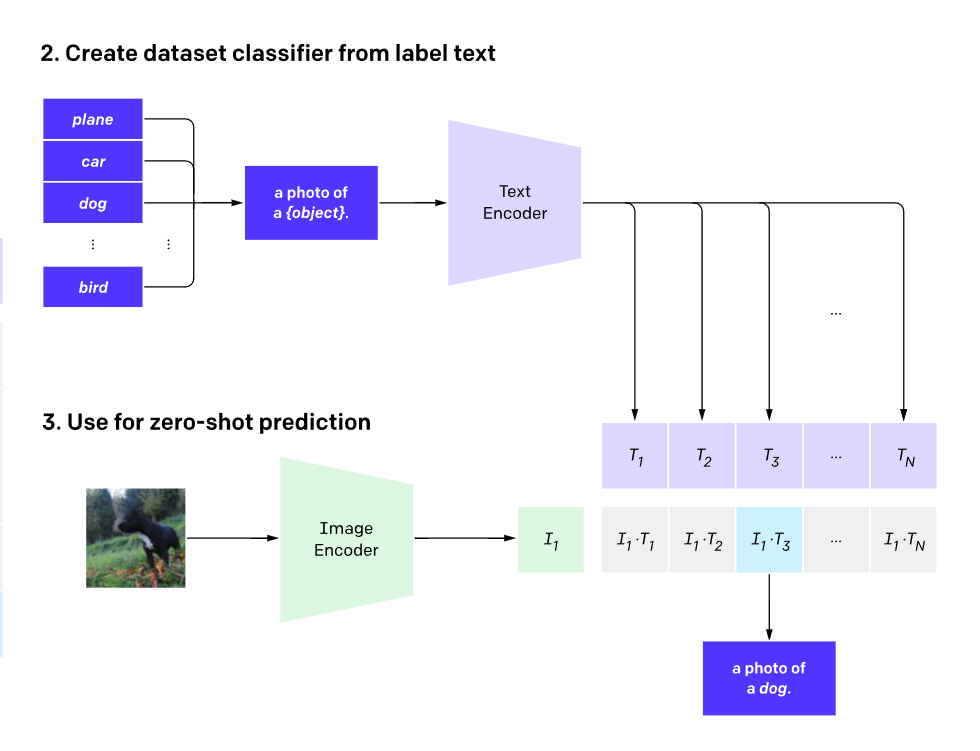

In [ ]:
resnet_model.eval()
image_projector.eval()

def create_image_embeddings(images):
    with torch.no_grad():
        image_embeddings = resnet_model(images)
        image_projection = image_projector(image_embeddings[:,:,0,0])
    return image_projection

image_embeddings_list_train = []

for index in tqdm(range(len( train_dataset ))):
    images = train_dataset[index][0]
    images = images.to(device)
    image_projection = create_image_embeddings(images.unsqueeze(0))
    image_embeddings_list_train.append( image_projection[0] )
    
    
def image_retrieval_function( input_query, n , display=False): # n --> number of images
    with torch.no_grad():
        inputs = tokenizer(input_query, return_tensors='pt', padding="max_length", max_length=max_length, truncation=True)
        inputs = inputs.to(device)
        outputs = text_model(**inputs)
        text_embeddings = outputs.last_hidden_state.mean(dim=1)
        text_projection = text_projector(text_embeddings)
    
    similarity_scores_list = []
    for index in tqdm(range(len(image_embeddings_list_train))):
        score = torch.dot( text_projection[0], image_embeddings_list_train[index] )
        similarity_scores_list.append( score.cpu().numpy() )
    
    max_indexes = np.array(similarity_scores_list).argsort()[-n:][::-1]
    if display:
        for index in max_indexes:
            image_tensor = train_dataset[index][0]
            plt.imshow( torch.moveaxis(image_tensor, 0,2) )
            plt.show()
        return None
    else:
        return max_indexes

In [ ]:
input_query = "dog"
image_retrieval_function( input_query, n=3, display=True )

In [ ]:
input_query = "man"
image_retrieval_function( input_query, n=3, display=True )

In [ ]:
input_query = "women"
image_retrieval_function( input_query, n=5, display=True )

In [ ]:
input_query = "bike on the road"
image_retrieval_function( input_query, n=2, display=True )

# Training Model - ViT + Distil BERT

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
#   - - - - - - - - - - - - - - - - - -   Hyperparameters    - - - - - - - - - - - - - - - - - -
shared_embedding_size = 512  # d_e shared embedding space

#  - - - - - - - - - - - - - - - - - -   Create model components   - - - - - - - - - - - - - - - - - -
# - - - - - - - - - ViT Model - - - - - - - - -
image_size = 256
patch_size = 16
d_model = 512*4
n_heads = 8
dim_feedforward = 2048
num_layers = 12
image_embedding_size=1024  # d_i

ViT_model = VisionTransformer(image_size, patch_size, d_model, n_heads, image_embedding_size, dim_feedforward, num_layers).to(device)
print(" Number of Trainable Parameters in", " ViT model :  ",   count_trainable_parameters(ViT_model))

# - - - - - - - - -  Distil BERT Model  - - - - - - - - -
max_length = 32
text_embedding_size = 768  # d_i

# Load pre-trained DistilBERT model and tokenizer
model_name = 'distilbert-base-uncased'
text_tokenizer = DistilBertTokenizer.from_pretrained(model_name) # .to(device)
text_model = DistilBertModel.from_pretrained(model_name ).to(device)
print(" Number of Trainable Parameters in", " DistilBERT model :  ",   count_trainable_parameters(text_model))


# - - - - - - - - -  Projections  - - - - - - - - -
image_projector = ImageProjection(image_embedding_size, shared_embedding_size).to(device)
print(" Number of Trainable Parameters in", " Image Projection :  ",   count_trainable_parameters(image_projector))
text_projector = TextProjection(text_embedding_size, shared_embedding_size).to(device)
print(" Number of Trainable Parameters in", " Text Projection :  ",   count_trainable_parameters(text_projector))
print("\n - - - - - - - - - - \n \n  Training......  ")

# - - - - - - - - -  Loss  - - - - - - - - -
# sym_loss_fn = SymmetricalLoss(margin=0.1).to(device)
# contrastive_loss = ContrastiveLoss(temperature=0.9)

# - - - - - - - - -  Optimizer  - - - - - - - - -
# optimizer = optim.AdamW( list(ViT_model.parameters())+ list(text_model.parameters()) + list(image_projector.parameters()) + list(text_projector.parameters()), lr=learning_rate )
params = [{"params":ViT_model.parameters(), "lr":1e-3 }, {"params":text_model.parameters(), "lr":1e-4}, 
          # {"params":image_projector.parameters(), "lr": }, {"params":text_projector.parameters(), "lr":}
          {"params": itertools.chain( image_projector.parameters(), text_projector.parameters() ), "lr":1e-3 , "weight_decay":1e-3 }
         ]
optimizer = optim.AdamW( params,  weight_decay=0.0 )
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau( optimizer, mode="min", patience=1 , factor=0.8 )

# import torch.optim.lr_scheduler as lr_scheduler
# scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5) # step_size=step_size
# warmup_epochs = 25  # Number of epochs for warm-up

# - - - - - - - - -  Training loop  - - - - - - - - -
for epoch in range(num_epochs):
    print( " - - - - - - - - - - - Epoch:", epoch+1, " - - - - - - - - - - - - "  )
    ViT_model.train()
    text_model.train()
    image_projector.train()
    text_projector.train()
    total_loss = 0.0
    
    for batch_idx, (images, texts) in enumerate(train_dataloader):
        # - - - - - - - - -  Forward pass  - - - - - - - - -
        optimizer.zero_grad()
        
        # - - - -  Text  - - - - 
        inputs = tokenizer(texts, return_tensors='pt', padding="max_length", max_length=max_length, truncation=True)
        inputs = inputs.to(device)
        outputs = text_model(**inputs)
        text_embeddings = outputs.last_hidden_state[:, 0, :] # outputs.last_hidden_state.mean(dim=1)
        text_projection = text_projector(text_embeddings)
        
        # - - - -  Image  - - - - 
        images = images.to(device)
        image_embeddings = ViT_model(images)
        image_projection = image_projector(image_embeddings)
        
        # - - - -  Compute Loss  - - - -
        # loss = sym_loss_fn(image_projection, text_projection)
        # loss = contrastive_loss(image_projection, text_projection)
        loss = contrastive_clip_loss_function( text_projection,  image_projection, mode="train")
        
        # - - - -  Backpropagation  - - - -
        loss.backward()
        optimizer.step()
        
#     if epoch < warmup_epochs:
#         scheduler.step(epoch)
#     else:
#         scheduler.step()
        
        # - - - - Loss print - - - -
        total_loss += loss.item()
        
        if batch_idx % 200 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx}/{len(train_dataloader)}], Loss: {total_loss/((batch_idx+1)*batch_size):.4f}")
    
    
    # - - - - Loss each epoch
    avg_loss = total_loss / len(train_dataloader)
    lr_scheduler.step(avg_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.4f}")

In [ ]:
"""
# 11891904 + 22155456 + 66362880 + 105987072 

try:
    checkpoint = {
        'ViT_model_dict': ViT_model.state_dict(),
        # 'resnet_model_dict': resnet_model.state_dict(),
        'text_model_dict': text_model.state_dict(),
        'image_projector_dict': image_projector.state_dict(),
        'text_projector_dict': text_projector.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }
    torch.save(checkpoint, "/kaggle/working/CLIP_model_from_Scratch_ResNet_DistilBERT")
    
except:
    print("Error in some saving")
    
"""

# Inference | Image Retrieval | ViT Setup

In [ ]:
ViT_model.eval()
image_projector.eval()

def create_image_embeddings(images):
    with torch.no_grad():
        image_embeddings = ViT_model(images)
        image_projection = image_projector(image_embeddings)
    return image_projection

image_embeddings_list_train = []

for index in tqdm(range(len( train_dataset ))):
    images = train_dataset[index][0]
    images = images.to(device)
    image_projection = create_image_embeddings(images.unsqueeze(0))
    image_embeddings_list_train.append( image_projection[0] )
    
    
def image_retrieval_function( input_query, n , display=False): # n --> number of images
    with torch.no_grad():
        inputs = tokenizer(input_query, return_tensors='pt', padding="max_length", max_length=max_length, truncation=True)
        inputs = inputs.to(device)
        outputs = text_model(**inputs)
        text_embeddings = outputs.last_hidden_state.mean(dim=1)
        text_projection = text_projector(text_embeddings)
    
    similarity_scores_list = []
    for index in tqdm(range(len(image_embeddings_list_train))):
        score = torch.dot( text_projection[0], image_embeddings_list_train[index] )
        similarity_scores_list.append( score.cpu().numpy() )
    
    max_indexes = np.array(similarity_scores_list).argsort()[-n:][::-1]
    if display:
        for index in max_indexes:
            image_tensor = train_dataset[index][0]
            plt.imshow( torch.moveaxis(image_tensor, 0,2) )
            plt.show()
        return None
    else:
        return max_indexes

In [ ]:
input_query = "dog"
image_retrieval_function( input_query, n=3, display=True )

In [ ]:
input_query = "man"
image_retrieval_function( input_query, n=3, display=True )

In [ ]:
input_query = "women"
image_retrieval_function( input_query, n=5, display=True )

In [ ]:
input_query = "bike on the road"
image_retrieval_function( input_query, n=5, display=True )

# Evaluation | Testing

In [ ]:
accuracy_counter = 0

# ViT_model.eval()
resnet_model.eval()
text_model.eval()
image_projector.eval()
text_projector.eval()

# cosine_similarity = CosineSimilarity(temperature=temperature_value)

with torch.no_grad():
    for batch_images, batch_captions in tqdm(train_dataloader):
        batch_size = batch_images.size(0)
        
        # - - - - - - - - -  Forward pass  - - - - - - - - -
        # - - - -  Text  - - - - 
        inputs = tokenizer(batch_captions, return_tensors='pt', padding="max_length", max_length=max_length, truncation=True)
        inputs = inputs.to(device)
        outputs = text_model(**inputs)
        text_embeddings = outputs.last_hidden_state.mean(dim=1)
        text_projection = text_projector(text_embeddings)
        
        # - - - -  Image  - - - -  
        batch_images = batch_images.to(device)
#         image_embeddings = ViT_model(batch_images)
#         image_projection = image_projector(image_embeddings)
        image_embeddings = resnet_model(batch_images)
        image_projection = image_projector(image_embeddings[:,:,0,0])
        
        # Calculate cosine similarities
        for index_text in range(batch_size):
            similarity_scores_list = []
            for index_image in range(len(image_projection)):
                score = torch.dot( text_projection[index_text], image_projection[index_image] )
                similarity_scores_list.append( score.cpu().numpy() )
            similarity_scores_list = np.array(similarity_scores_list)
        
            max_index = np.argmax(similarity_scores_list)
            if max_index==index_text:
                accuracy_counter += 1
        
#         # Convert indices to captions for comparison
#         batch_pred_captions = [batch_captions[index] for index in batch_pred_indices]
#         batch_actual_captions = batch_captions
        
#         # Calculate accuracy
#         for pred_caption, actual_caption in zip(batch_pred_captions, batch_actual_captions):
#             if pred_caption == actual_caption:
#                 accuracy_counter += 1

total_samples = len(train_dataloader.dataset)
accuracy = accuracy_counter / total_samples
print(f"Accuracy (Pencentage of Correct Matching): {accuracy*100:.4f}")

In [ ]:
accuracy_counter = 0

# ViT_model.eval()
resnet_model.eval()
text_model.eval()
image_projector.eval()
text_projector.eval()

# cosine_similarity = CosineSimilarity(temperature=temperature_value)

with torch.no_grad():
    for batch_images, batch_captions in tqdm(test_dataloader):
        batch_size = batch_images.size(0)
        
        # - - - - - - - - -  Forward pass  - - - - - - - - -
        # - - - -  Text  - - - - 
        inputs = tokenizer(batch_captions, return_tensors='pt', padding="max_length", max_length=max_length, truncation=True)
        inputs = inputs.to(device)
        outputs = text_model(**inputs)
        text_embeddings = outputs.last_hidden_state.mean(dim=1)
        text_projection = text_projector(text_embeddings)
        
        # - - - -  Image  - - - -  
        batch_images = batch_images.to(device)
        image_embeddings = resnet_model(batch_images)
        image_projection = image_projector(image_embeddings[:,:,0,0])
        
        # Calculate cosine similarities
        for index_text in range(batch_size):
            similarity_scores_list = []
            for index_image in range(len(image_projection)):
                score = torch.dot( text_projection[index_text], image_projection[index_image] )
                similarity_scores_list.append( score.cpu().numpy() )
            similarity_scores_list = np.array(similarity_scores_list)
        
            max_index = np.argmax(similarity_scores_list)
            if max_index==index_text:
                accuracy_counter += 1

total_samples = len(test_dataloader.dataset)
accuracy = accuracy_counter / total_samples
print(f"Accuracy (Pencentage of Correct Matching): {accuracy*100:.4f}")

# References:

Image Reference: https://www.youtube.com/watch?v=GLa7z5rkSf4

Paper: https://arxiv.org/abs/2103.00020

Website: https://openai.com/research/clip

Vision Transformer Model (ViT) : https://arxiv.org/pdf/2010.11929v2.pdf  |  https://huggingface.co/docs/transformers/main/model_doc/vit